In [1]:
# 基础运算库
import numpy as np
# 深度学习库
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
# 辅助绘图库
import matplotlib.pyplot as plt
# 时间操作库
import time
# 进度条控制库
from tqdm import tqdm

# CIFAR-10图像分类

## 前置准备

&emsp;&emsp;本项目使用的数据集可以从torchvision库中直接导出，下面是一些基础数据操作（数据下载可能需要几分钟，请耐心等待）。<br>

In [2]:
##定义对图像的各种变换操作，包括把array转换为tensor，对图像做正则化
#transforms.Compose主要是用于常见的一些图形变换，例如裁剪、旋转
#遍历list数组，对img依次执行每个transforms操作
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.48216, 0.44653),
                                                     (0.24703, 0.24349, 0.26159))])
#导出torchvision里的CIFAR10数据集，root是把数据下载之后存放的目录，train控制是不是在训练阶段，download控制是不是需要下载，transform把一系列的图像变换传入进来。
trainset = torchvision.datasets.CIFAR10(root='/data/course_data/AI/AI_homework_6/',
                                        train=True, 
                                        download=True, 
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='/data/course_data/AI/AI_homework_6/',
                                       train=False, 
                                       download=True, 
                                       transform=transform)
#用来把训练数据分成多个小组，此函数每次抛出一组数据。
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=16,
                                          shuffle=True)
#用来把测试数据分成多个小组，此函数每次抛出一组数据。
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=16, 
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


&emsp;&emsp;数据下载完成后，我们就可以简单查看数据label，看看是否和练习说明中的数据集介绍对的上。<br>

In [3]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

&emsp;&emsp;下面我们再来检查一下数据图像。<br>

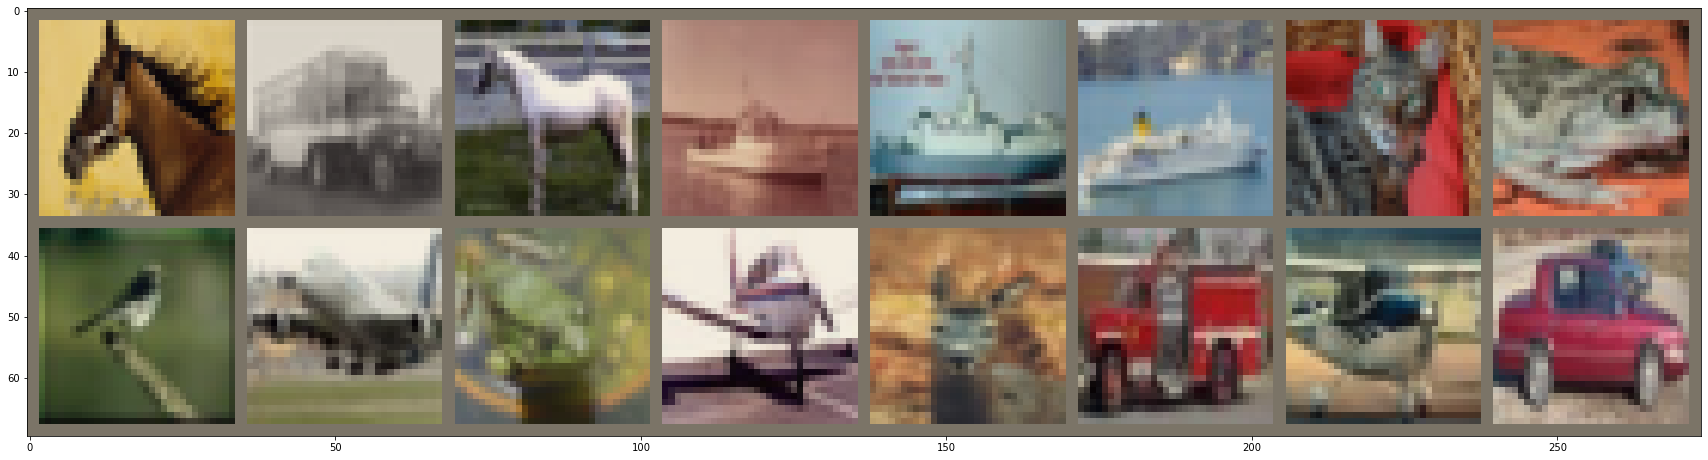

In [4]:
#把图片进行可视化展示
#定义画图的函数
def imshow(inp, title=None):
    """Imshow for Tensor."""
    #定义画图的画布
    fig = plt.figure(figsize=(30, 30))
    #转换图片的纬度
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #对图片进行标准化
    inp = std * inp + mean
    #整个图片数组的值限制在指定值a_min,与a_max之间
    inp = np.clip(inp, 0, 1)
    #对图片进行可视化展示
    plt.imshow(inp, )

# 获取一个batch的数据
inputs, classes = next(iter(trainloader))

# 以网格的格式展示，作用是将若干幅图像拼成一幅图像
out = torchvision.utils.make_grid(inputs)
# plt.imshow()就可显示图片同时也显示其格式。
imshow(out, title=[trainset.classes[x] for x in classes])

## 搭建简单神经网络
&emsp;&emsp;数据准备就绪后，就需要你来搭建一个简单神经网络。<br>
&emsp;&emsp;<font color=red>请补全下列代码，定义一个3层全连接神经网络，输入维度是32*32*3，第一层输出维度是1000，第二层输出维度是500，第三层输出维度是10。</font><br>

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(32*32*3, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
#实例话神经网络的类
net = Net()

&emsp;&emsp;在定义好模型结构之后，还需确定损失函数及优化器。<br>

In [10]:
# 定义损失函数-交叉熵
criterion = nn.CrossEntropyLoss()
# 定义优化器，将神经网络的参数都传入优化器，并定义学习率
optimizer = optim.Adam(net.parameters(), lr=3e-4)

## 神经网络的训练

&emsp;&emsp;模型主要内容都已完成，下面就可以进行训练了。在模型训练过程中，一般遵循如下步骤：<br>
1. 大for循环-epochs，用于管理一套数据循环训练几遍<br>
1. 小for循环-step，用于以batchsize为单位，从dataloader中调取数据<br>
1. 清空优化器的梯度<br>
1. 读入data和label，并进行形状变换（可做可不做）<br>
1. 运行模型前向传播过程<br>
1. 基于模型输出生成最终结果<br>
1. 计算损失<br>
1. 基于损失计算梯度<br>
1. 基于梯度更新参数<br>

&emsp;&emsp;<font color=red>请补全代码，训练模型。（相关代码已经提供在练习指导中，你需要根据模型训练步骤，将代码段逐一填入下列代码中）*</font><br>

In [11]:
num_epochs = 10
since = time.time()
net.train()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    
    running_loss = 0.0
    running_corrects = 0
    # 从trainloader里循环取出每一批次数据，
    for data in tqdm(trainloader):

        optimizer.zero_grad() # 用于清空优化器梯度
        inputs, labels = data # 用于读入data和label
        inputs = inputs.view(-1, 32 * 32 * 3) # 用于对输入进行形状变换
        outputs = net(inputs) # 用于模型前向传播
        _, preds = torch.max(outputs, 1) # 用于生成最终输出结果
        loss = criterion(outputs, labels) # 用于计算损失
        loss.backward() # 用于计算梯度
        optimizer.step() # 用于参数更新
        
        
        # 一个批次数据的损失函数的计算
        running_loss += loss.item() * inputs.size(0)
        # 一个批次数据准确率的计算
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / trainloader.dataset.data.shape[0]
    epoch_acc = running_corrects.double() / trainloader.dataset.data.shape[0]
    
    print('train Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))
    print('-' * 10)
    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

  0%|          | 6/3125 [00:00<01:15, 41.16it/s]

Epoch 1/10


  0%|          | 3/3125 [00:00<02:04, 25.12it/s]

train Loss: 1.6375 Acc: 0.4210
----------
Epoch 2/10


  0%|          | 3/3125 [00:00<01:56, 26.86it/s]

train Loss: 1.4276 Acc: 0.4962
----------
Epoch 3/10


  0%|          | 4/3125 [00:00<01:27, 35.58it/s]

train Loss: 1.3048 Acc: 0.5362
----------
Epoch 4/10


  0%|          | 3/3125 [00:00<01:48, 28.82it/s]

train Loss: 1.2061 Acc: 0.5742
----------
Epoch 5/10


  0%|          | 3/3125 [00:00<02:53, 17.95it/s]

train Loss: 1.1095 Acc: 0.6065
----------
Epoch 6/10


  0%|          | 3/3125 [00:00<01:45, 29.50it/s]

train Loss: 1.0216 Acc: 0.6358
----------
Epoch 7/10


  0%|          | 3/3125 [00:00<01:46, 29.31it/s]

train Loss: 0.9278 Acc: 0.6705
----------
Epoch 8/10


  0%|          | 3/3125 [00:00<01:58, 26.36it/s]

train Loss: 0.8466 Acc: 0.6988
----------
Epoch 9/10


  0%|          | 3/3125 [00:00<01:53, 27.54it/s]

train Loss: 0.7666 Acc: 0.7271
----------
Epoch 10/10


100%|██████████| 3125/3125 [01:59<00:00, 26.20it/s]

train Loss: 0.6922 Acc: 0.7519
----------
Training complete in 19m 50s


## 模型测评

&emsp;&emsp;完成模型训练后，还需对模型进行测评，验证模型在测试集上的精度。<br>
Tips：在模型训练日志中，也有打印精确度acc，但这是模型在训练集上的精度，而不是测试集上的精度哦。你可以观察观察训练集精度与测试集精度，看看有没有什么差异。<br>
&emsp;&emsp;<font color=red>请补全下列代码，完成模型测评</font><br>

In [12]:
# TODO： 补全下列代码，完成模型测评
correct, total = 0, 0
net.eval()
for data in tqdm(testloader):
    
    inputs, labels = data
    inputs = inputs.view(-1, 32 * 32 * 3)
    outputs = net(inputs)
    
    _, predicted = torch.max(outputs, 1) 
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))

100%|██████████| 625/625 [00:06<00:00, 91.87it/s] 

The testing set accuracy of the network is: 53 %
